# DG tutorial Part 2: going to higher order

In the previous notebook, we considered one of the simplest possible DG discretizations for the 1D scalar advection equation.  It turned out that approximating the solution using only two basis functions worked, but required a large number of elements to get a result reasonably close to the analytic solution.

In this notebook, we consider the same problem but increase the number of basis functions used to approximate the solution within each element.

As before, we begin by importing various libraries and functions.

In [8]:
#define imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import quad
from numpy.linalg import inv
from scipy.interpolate import lagrange
from scipy.special import roots_legendre

# Set plot parameters (credit: Mani Chandra)
pl.rcParams['figure.figsize']  = 5, 3
pl.rcParams['lines.linewidth'] = 2
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'large'
pl.rcParams['figure.dpi']      = 300

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'large'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'large'
pl.rcParams['ytick.direction']  = 'in'

## Changing the basis from monomials to Lagrange

Before, we chose for our basis functions the set of monomial functions $\psi_j(\xi) \sim \xi^j$ and we only used a total of two basis functions to construct our solution.

It turns out that the monomial basis is a poor choice for constructing a DG scheme, as the mass matrix is ill-conditioned (see [link]).

Instead, we will for our basis the first $M+1$ _Lagrange polynomials_
$$
\psi_j(x) = \prod_{i=0, i \neq j}^{M} \frac{x - x_i}{x_j - x_i}.
$$
Given an arbitrary set of data points $(x_i, y_i)$, the lowest-order interpolating polynomial through those data points can be written as a linear combination of the Lagrange polynomials $\psi_j(x)$.

### Choice of collocation points

In our case, we are approximating the solution within a given cell using a Lagrange interpolating polynomial which is most accurate at the interpolating points $x_i$ (which, in this context, are called collocation points).  How do we choose these points?

The python cell below explores two choices: (1) $x_i$ evenly spaced through the cell, and (2) $x_i$ spaced according to the roots of the Legendre polynomials.

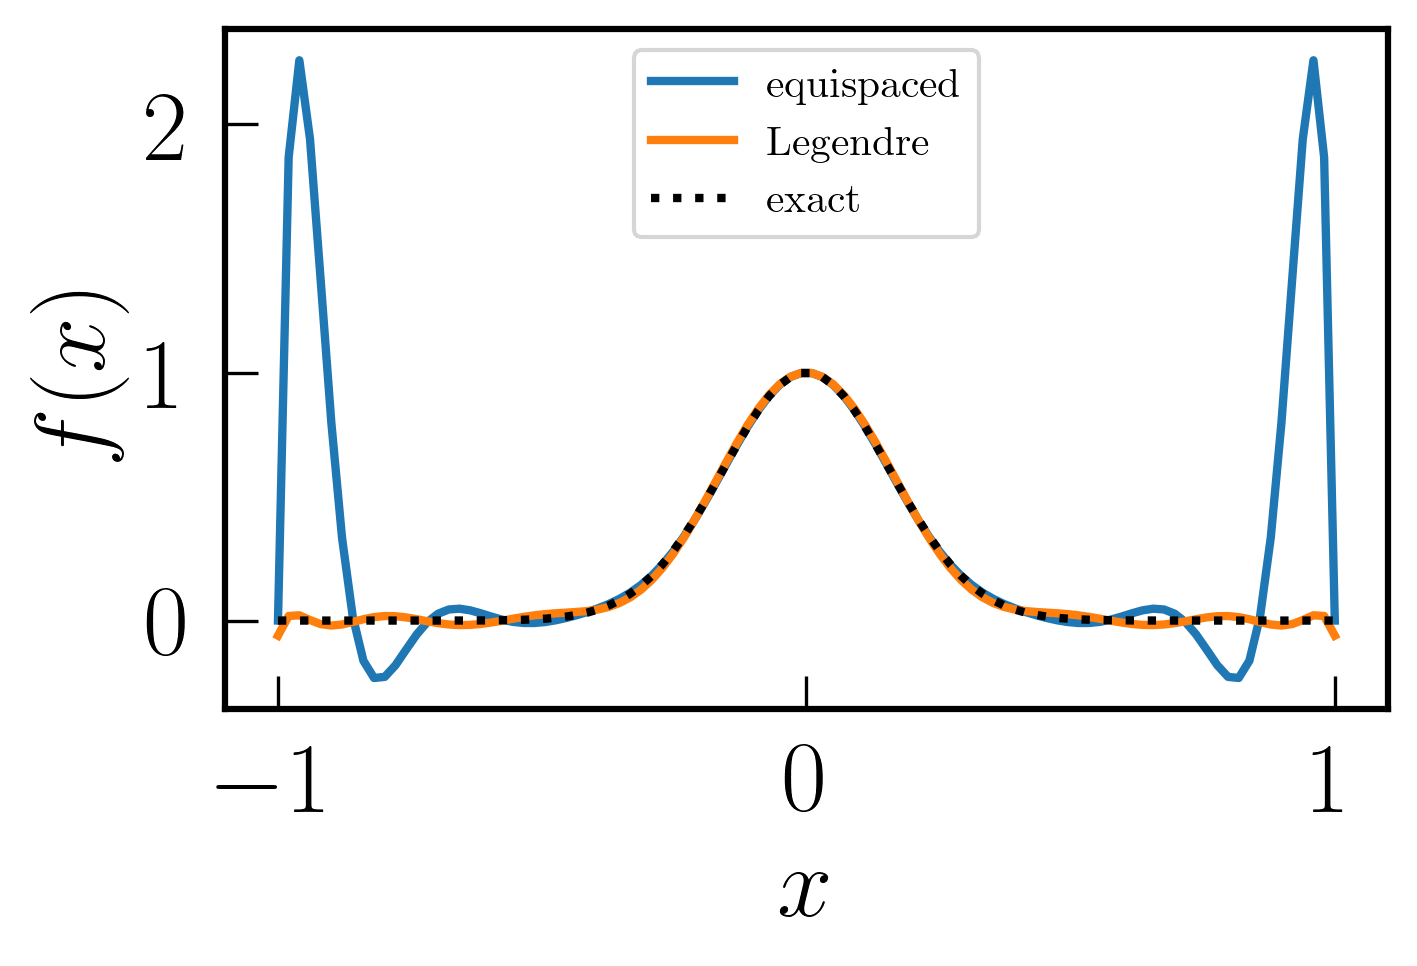

In [25]:
#define a simple function
def f(x):
    return np.exp(-x**2./0.05)

#define equispaced points
numPoints     = 15
equispaced    = np.linspace(-1, 1, numPoints)
LegendreRoots = roots_legendre(numPoints)[0]

#generate Lagrange interpolating polynomial
fEqui = lagrange(equispaced, f(equispaced))
fLeg  = lagrange(LegendreRoots, f(LegendreRoots))

xx = np.linspace(-1, 1, 100)

#plot interpolating functions with equispaced
#interpolation points, interp points at Legendre
#roots, and the exact function
pl.plot(xx, fEqui(xx), label='equispaced')
pl.plot(xx, fLeg(xx), label='Legendre')
pl.plot(xx, f(xx), 'k:', label='exact')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.legend(fontsize='10')
pl.show()

Set up the grid, initialize coefficient matrices, define roots of Legendre polynomials.

In [76]:
#set up grid
N = 7 #number of elements
M = 7 #number of modes j

#get Legendre roots; we don't need weights
LegendreRoots, weights = roots_legendre(M)

#define a_n to be a (N elements, M modes) array
a_n   = np.zeros((N, M))
a_np1 = np.zeros((N, M))

#define CFL
CFL = 0.005

#define number of timesteps, TS
TS = 250

#set up grid
xMax = 1.
xMin = 0.

#define size of a cell, dx
dx = (xMax-xMin)/N
dt = CFL * dx

#define wave speed c
c = 1.

The cell below contains all of the code for the evolution scheme.

In [77]:
#define Lagrange interpolating polynomial; take x in [-1, 1], 
#nodes (list of Legendre roots up to order M)
def LagrangePoly(xi, j, nodes):
    order = len(nodes)
    
    poly  = 1
    for i in range(order):
        if(i != j):
            poly *= (xi-nodes[i])/(nodes[j]-nodes[i])
            
    return poly

#define first derivative of Lagrange polynomial
def dLagrangePoly(xi, j, nodes):
    order = len(nodes)
    
    poly = 0
    for i in range(order):
        if(i != j):
            poly += 1./(xi-nodes[i])
            
    poly *= LagrangePoly(xi, j, nodes)
    
    return poly

#define coordinate mapping from cell index k
#and logical coordinate xi to global coordinate x
def x(k, xi):
    return k*dx + (1+xi)/2*dx

#define Jacobian of coordinate transform dx/dxi
def J():
    return dx/2

#compute mass matrix:
def Mij(nodes):
    order = len(nodes)
    
    #define jacobian
    jacobian = J()
    
    M = np.zeros((order, order))
    for i in range(order):
        for j in range(order):
            M[i,j] = quad(lambda xi: 
                          jacobian
                          *LagrangePoly(xi,i,nodes)
                          *LagrangePoly(xi,j,nodes), -1, 1)[0]
            
    #set values smaller than eps to zero
    eps = 1e-15
    M[np.abs(M) < eps] = 0
    
    return M

#compute stiffness matrix; note that the first derivative
#of the Lagrange polynomials is numerically poorly behaved
#near the nodes, so pass points=nodes to quad to get it to
#treat those areas carefully
def Kij(nodes):
    order = len(nodes)
    
    K = np.zeros((order, order))
    
    for i in range(order):
        for j in range(order):
            K[i, j] = quad(lambda xi: 
                           dLagrangePoly(xi,i,nodes)
                           *LagrangePoly(xi,j,nodes), -1, 1,
                          points=nodes)[0]
    
    #set values smaller than eps to zero
    eps = 1e-15
    K[np.abs(K) < eps] = 0

    return K

#define solution approximation in element indexed k
#from coefficient matrix a_n[k, j]
def qt(k, xi, a_n, nodes):
    #a_n has shape (N elements, M modes)
    N, M = np.shape(a_n)
        
    q = 0
    for j in range(M):
        q += a_n[k, j]*LagrangePoly(xi, j, nodes)

    return q

#define the flux (boundary term) for element indexed k;
#return a vector of net fluxes of length M (# of modes)
def f(k, a_n, nodes):
    N, M = np.shape(a_n)
    
    #define xiR, xiL, left and right cell boundaries
    #in terms of logical coordinate xi
    xiR = 1
    xiL = -1
    
    flux = np.zeros(M)
    for j in range(M):
        #define upwind flux at right cell boundary
        fxR     = c*qt(k, xiR, a_n, nodes)
        #define upwind flux at left cell boundary
        fxL     = c*qt(k-1, xiR, a_n, nodes)
        #define net flux
        flux[j] = fxR*LagrangePoly(xiR,j,nodes) - fxL*LagrangePoly(xiL,j,nodes)
        
    return flux

#define RHS function
def RHS(k, a_n, Minv, K, nodes):
    return np.dot(Minv, c*np.dot(K, a_n[k])-f(k, a_n, nodes))

#define evolve() function which returns a_np1 given a_n
def evolve(a_n, a_np1, Minv, K, nodes):
    N, M = np.shape(a_n)
    
    #for each element compute a at the next time level
    for k in range(N):
        a_np1[k] = a_n[k] + dt*RHS(k, a_n, Minv, K, nodes)

    return a_np1

#evolve system TS timesteps; takes in # of timesteps TS,
#coefficient vector at initial time a_n, and empty
#coefficient vector at advanced time a_np1
def evolve_TS_steps(TS, a_n, a_np1, nodes):
    #compute mass matrix, stiffness matrix, inverse of
    #mass matrix; do this just once per evolution,
    #since these are all constant matrices
    K    = Kij(nodes)
    M    = Mij(nodes)
    Minv = inv(M)

    #get N (# elements) and M (polynomial order)
    N, M = np.shape(a_n)
    
    #save all data to an array called sol, starting with ID
    sol = a_n
    
    for n in range(TS):
        a_np1 = evolve(a_n, a_np1, Minv, K, nodes)
        #append a_np1 to sol
        sol = np.append(sol, a_np1)
        #copy a_np1 into a_n for next timestep
        a_n = a_np1

    #reshape sol to be (TS, N, M), so sol[n] = a_n 
    #at time level n
    return np.reshape(sol, (TS+1, N, M))

Define a function to plot the solution given the coefficient matrix a_n, the list of nodes, and an optional matplotlib style string.

In [78]:
#plot q(x) given a_n and nodes
def plot_sol(a_n, nodes, StyleString=''):
    #xi in each element
    xi = np.linspace(-1, 1, 100)

    #plot approximate solution qtilde(x)
    for k in range(N):
        pl.plot(x(k,xi), qt(k, xi, a_n, nodes), StyleString)

    #pl.show()

Define initial data by specifying $q(t=0, x)$; here we just set it to be a Gaussian.

In [79]:
#define initial data
def q_ID(x):
    mu = 0.5
    sigma = 0.05
    return np.exp(-(x-mu)**2./sigma**2.)

#populate coefficient matrix a_n with values corresponding to ID
def compute_ID_a(a_n, nodes):
    N, M = np.shape(a_n)
    
    for k in range(N):
        for j in range(M):
            xi        = nodes[j]
            a_n[k, j] = q_ID(x(k, xi))
            
    return a_n

In the cell below we specify initial data and compute the corresponding coefficient matrix a_n, then evolve the system forward through time TS steps.

In [80]:
#set initial data
a_n = compute_ID_a(a_n, LegendreRoots)

#evolve the system forward TS timesteps and store
#result in soln
soln = evolve_TS_steps(TS, a_n, a_np1, LegendreRoots)

Plot the solution at $t = 0$ and $t = \mathrm{TS} \cdot \Delta t$.

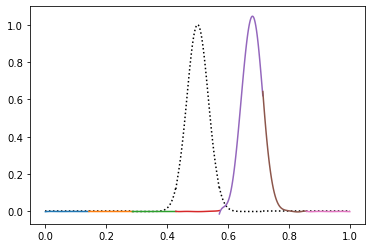

In [81]:
plot_sol(soln[0], LegendreRoots, 'k:')
plot_sol(soln[TS], LegendreRoots)
pl.show()

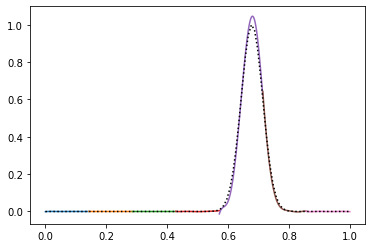

In [82]:
#define analytic solution
def q_analytic(t, x):
    #define coordinate u
    u = x-c*t
    #account for periodic BCs
    u_periodic = u%(xMax-xMin)
    return q_ID(u_periodic)

xx = np.linspace(xMin, xMax-1e-7, 100)

plot_sol(soln[TS], LegendreRoots)
pl.plot(xx, q_analytic(TS*dt, xx), 'k:')

In [83]:
#define solution as a function of global coord x
def qt_of_x(x, a_n, nodes):
    #given a value of x, get k and xi
    k  = (x/dx).astype(int) #note: this assumes x > 0
    xi = 2*(x/dx-k) - 1

    return qt(k, xi, a_n, nodes)

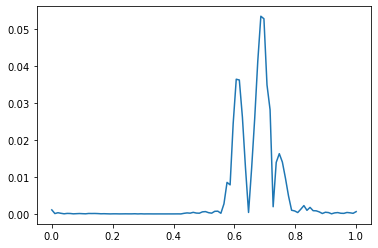

In [85]:
#plot error vs analytic solution
pl.plot(xx, np.abs(qt_of_x(xx, soln[TS], LegendreRoots)-q_analytic(TS*dt,xx)))